In [1]:
import os
os.chdir("..")
os.getcwd()

'/Users/laurasisson/odor-pair'

In [2]:
import torch

test_trues = [torch.load(f"paperdata/fold_preds/{fold_idx}_true.pt") for fold_idx in range(4)]
test_preds = [torch.load(f"paperdata/fold_preds/{fold_idx}_pred.pt") for fold_idx in range(4)]

In [3]:
for tp, tt in zip(test_preds,test_trues):
    print(tp.shape,tt.shape)

torch.Size([10825, 49]) torch.Size([10825, 49])
torch.Size([10338, 53]) torch.Size([10338, 53])
torch.Size([9713, 48]) torch.Size([9713, 48])
torch.Size([9259, 47]) torch.Size([9259, 47])


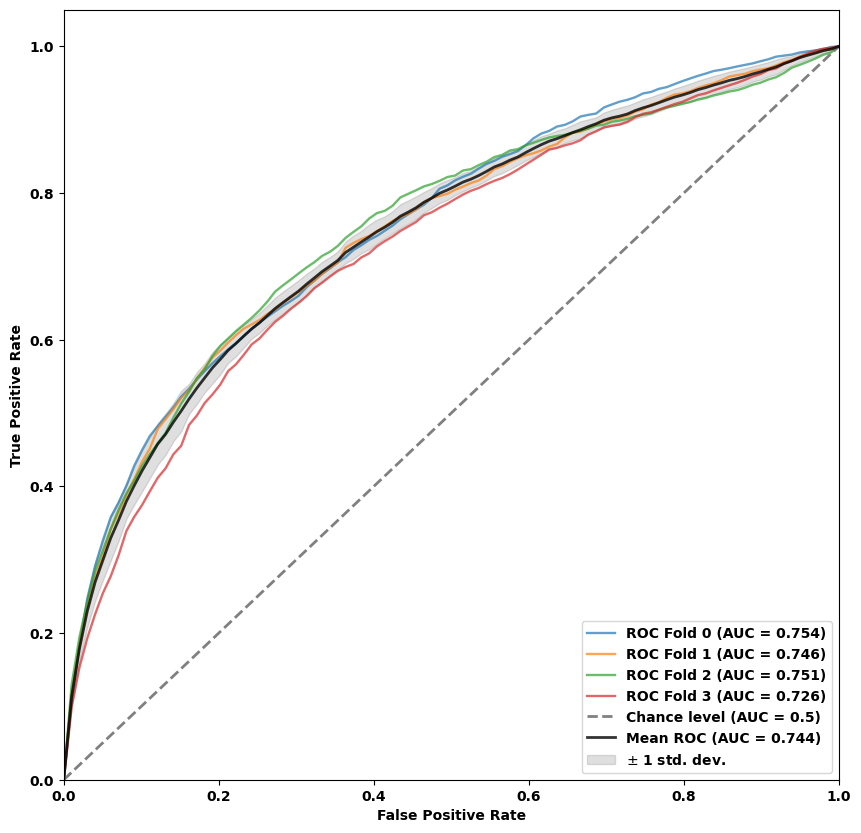

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
import utils

fig, ax = utils.standard_fig_ax()

# Assume test_preds and test_trues are lists of arrays (n_folds x n_tasks)
n_folds = len(test_preds)

# Initialize variables for storing ROC curves and AUC values
mean_fpr = np.linspace(0, 1, 100)  # Points at which to interpolate TPRs
tprs = []
aucs = []


# Loop through each fold
for i, (test_pred, test_true) in enumerate(zip(test_preds,test_trues)):
    fold_tprs = []
    
    tasks = test_true.shape[-1]
    # Loop through each task within the fold
    for task in range(tasks):
        fpr, tpr, _ = roc_curve(test_true[:, task], test_pred[:, task])
        fold_tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolate TPRs to common FPR points
        fold_tprs[-1][0] = 0.0  # Ensure TPR starts at 0

    # Aggregate TPRs for the tasks within this fold
    mean_fold_tpr = np.mean(fold_tprs, axis=0)
    mean_fold_tpr[-1] = 1.0  # Ensure TPR ends at 1
    tprs.append(mean_fold_tpr)
    fold_auc = auc(mean_fpr, mean_fold_tpr)
    aucs.append(fold_auc)
    
    # Plot the ROC curve for the current fold
    plt.plot(mean_fpr, mean_fold_tpr, lw=1.7, alpha=0.7, label=f'ROC Fold {i} (AUC = {fold_auc:.3f})')

# Calculate mean and standard deviation of TPRs across folds
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure TPR ends at 1
mean_auc = auc(mean_fpr, mean_tpr)
std_tpr = np.std(tprs, axis=0)

# Plot the diagonal line representing chance
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2, label='Chance level (AUC = 0.5)')

# Plot the mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='black', lw=2, alpha=0.8, label=f'Mean ROC (AUC = {mean_auc:.3f})')

# Plot the standard deviation band
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.25, label=r'$\pm$ 1 std. dev.')


# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

utils.save_figures(f"fold_auc_gin", fig)

plt.show()
